In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import re
import sys

In [55]:
import datetime as dt
import seaborn
style.use('seaborn')

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine('sqlite:///Resources/hawaii.sqlite', connect_args={'check_same_thread': False})

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from today

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data

# Rotate the xticks for the dates


In [11]:
#Verify the data in measurements table
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Latest Date
import datetime
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# Converting end date into datetime format
last_date = datetime.datetime.strptime(latest_date[0], '%Y-%m-%d')
# calculating the earliest date
first_date="%d-%d-%d"%(last_date.year-1,last_date.month,last_date.day)
#converting start date to date time 
start_date=datetime.datetime.strptime(first_date, '%Y-%m-%d').strftime("%Y-%m-%d")

last_date = last_date.strftime("%Y-%m-%d")

print("Start Date:%s\nEnd Date:%s"%(start_date,last_date))

Start Date:2016-08-23
End Date:2017-08-23


In [13]:
#12 months of data
twelve_months = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date>=start_date,Measurement.date <=last_date).order_by(Measurement.date.desc()).all()

#create data frame from sql query
twelve_months_prcip = pd.DataFrame(twelve_months)
twelve_months_prcip.set_index("date",inplace=True)
twelve_months_prcip.head()

,prcp
date,
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.45
2017-08-22,0.00


<IPython.core.display.Javascript object>


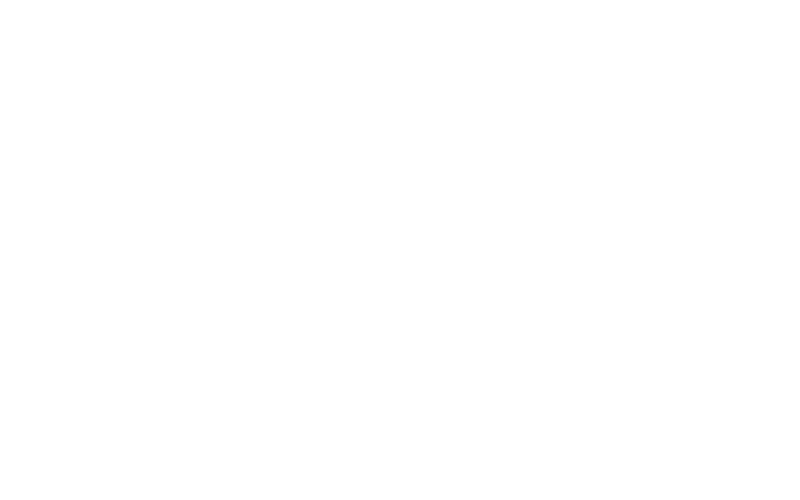

In [14]:
# plotting percipitation over the years

twelve_months_prcip.plot(rot=45,figsize=(8,5),grid=None)

plt.title("Precipition in Hawaii from 08/23/2016 to 08/23/2017")
plt.savefig("Images/percipitation_analysis.png")
plt.show()



In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
twelve_months_prcip.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# How many stations are available in this dataset?
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [17]:
# number of stations 
station_count = session.query(Station.id).group_by(Station.id).count()
station_count

9

In [18]:
# What are the most active stations?
# List the stations and the counts in descending order.
active_stations = session.query(Station.station, func.count(Measurement.tobs)).\
filter(Station.station == Measurement.station).group_by(Measurement.station).\
order_by(func.count(Measurement.tobs).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
#most active station
most_active_station = active_stations[0][0:2]
most_active_station

('USC00519281', 2772)

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
highest_temp = "USC00519281"
overall_calc = session.query(func.max(Measurement.tobs), func.min(Measurement.tobs),func.avg(Measurement.tobs)).\
filter(Measurement.station == highest_temp).all()
overall_calc


[(85.0, 54.0, 71.66378066378067)]

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

highest_results=session.query(Measurement.station,Measurement.date,Measurement.tobs).\
        filter(Measurement.date>=start_date, Measurement.date<=last_date, Measurement.station == highest_temp).\
        order_by(Measurement.date.desc()).all()


In [22]:
# Converting the results into a dataframe
Temp_DF=pd.DataFrame(highest_results)

# View the Temperature DataFrame
Temp_DF.head()

,station,date,tobs
0,USC00519281,2017-08-18,79.0
1,USC00519281,2017-08-17,76.0
2,USC00519281,2017-08-16,76.0
3,USC00519281,2017-08-15,77.0
4,USC00519281,2017-08-14,77.0


<IPython.core.display.Javascript object>


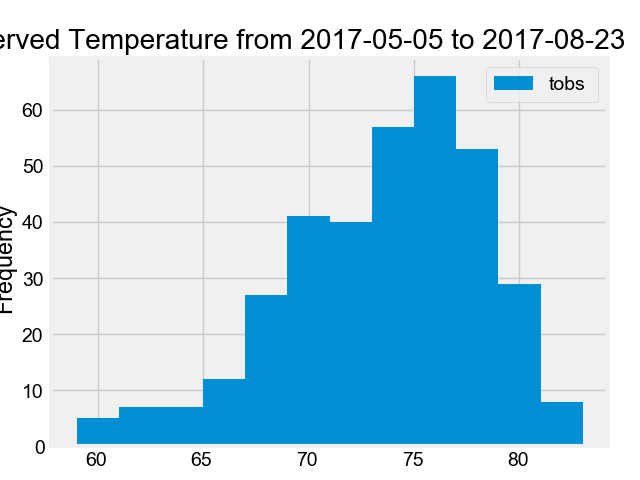

In [51]:
# Plotting histogram
from importlib import reload
reload(plt)
%matplotlib notebook
Temp_DF.plot.hist( bins=12, label='tobs',title = "Observed Temperature from %s to %s" %(start_date,last_date))
plt.ylabel("Frequency")
plt.legend()
plt.savefig("Images/station_analysis.png")
plt.show()

In [34]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates


def calc_temps(start_date,end_date):
    result = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
    Tmin = result[0][0]
    Tavg = result[0][1]
    Tmax = result[0][2]
    print("--------------------------------------------------")
    print("  Minimum Temperature: %d°F"%Tmin)
    print("  Average Temperature: %d°F"%Tavg)
    print("  Maximum Temperature: %d°F"%Tmax)
    return Tmin, Tavg, Tmax
    


In [35]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = input("Enter your trip start date(YYYY-MM-DD): ")
end_date = input("Enter your trip end date(YYYY-MM-DD): ")
temperature_results = calc_temps(start_date,end_date)

Enter your trip start date(YYYY-MM-DD): 2017-05-05
Enter your trip end date(YYYY-MM-DD): 2017-06-06
--------------------------------------------------
  Minimum Temperature: 66°F
  Average Temperature: 75°F
  Maximum Temperature: 87°F


<IPython.core.display.Javascript object>


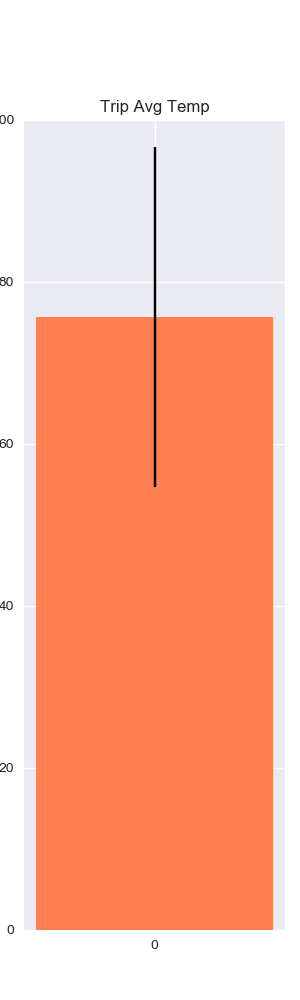

In [56]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(3,10))
error = temperature_results[2]-temperature_results[0]
plt.bar(0,temperature_results[1], yerr = error,color="coral")
plt.ylim(0,100)
plt.xticks([0])
plt.ylabel("Temp (°F)")
plt.title("Trip Avg Temp")
plt.grid(b=True,which="minor")
plt.show()

In [68]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = input("Enter your trip start date(YYYY-MM-DD):")
end_date = input("Enter your trip end date(YYYY-MM-DD):")

#convert start and End date to datetime form
start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d")

# previous years matching dates

previous_start_date = (start_date-datetime.timedelta(365)).strftime("%Y-%m-%d")
previous_end_date = (end_date-datetime.timedelta(365)).strftime("%Y-%m-%d")

# query to retrieve rainfall in each station 

query = session.query(Measurement.station, func.sum(Measurement.prcp), Station.latitude, Station.longitude,Station.elevation).\
          filter(Station.station == Measurement.station, Measurement.date >= previous_start_date, Measurement.date <= previous_end_date).\
          group_by(Measurement.station).\
          order_by(Measurement.station)

#rainfall and other details per station
rainfall_each_station = pd.read_sql(query.statement, query.session.bind)
rainfall_each_station

            

Enter your trip start date(YYYY-MM-DD):2017-04-04
Enter your trip end date(YYYY-MM-DD):2017-05-05


,station,sum_1,latitude,longitude,elevation
0,USC00513117,3.19,21.42340,-157.80150,14.6
1,USC00514830,2.23,21.52130,-157.83740,7.0
2,USC00516128,16.83,21.33310,-157.80250,152.4
3,USC00517948,0.04,21.39340,-157.97510,11.9
4,USC00519281,6.20,21.45167,-157.84889,32.9
5,USC00519397,0.59,21.27160,-157.81680,3.0
6,USC00519523,1.61,21.33556,-157.71139,19.5
